<a href="https://colab.research.google.com/github/EndreGuljas/AER850_Project2/blob/main/AER850_Project2_steps1_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4450 - loss: 1.6922 - val_accuracy: 0.3921 - val_loss: 1.4405 - learning_rate: 1.0000e-04
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5563 - loss: 0.9899 - val_accuracy: 0.4640 - val_loss: 1.6773 - learning_rate: 1.0000e-04
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6440 - loss: 0.7733 - val_accuracy: 0.4223 - val_loss: 1.8659 - learning_rate: 1.0000e-04
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6297 - loss: 0.7944 - val_accuracy: 0.4408 - val_loss: 1.7772 - learning_rate: 1.0000e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6949 - loss: 0.6755 - val_accuracy: 0.5081 - val_loss: 1.3738 - learning_rate: 2.0000e-05
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6954 - loss: 0.6740 - val_accuracy: 0.5406 - val_loss: 1.0888 - learning_rate: 2.00

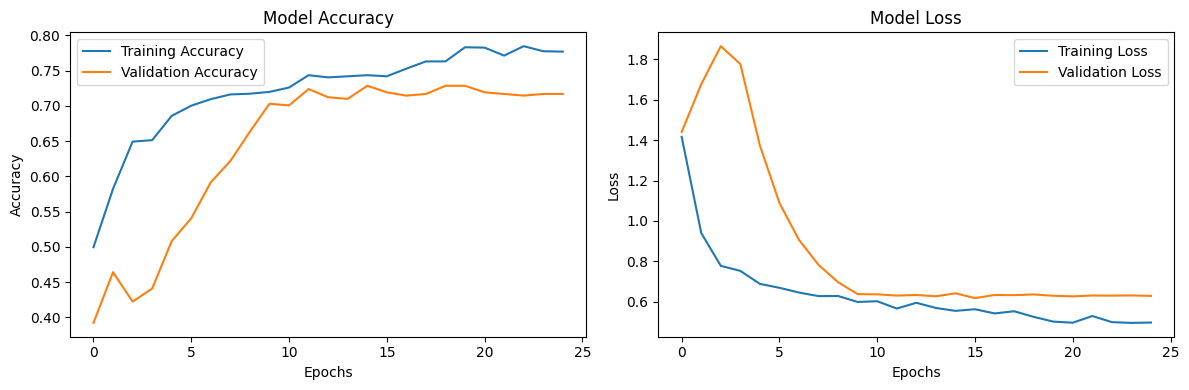

Model saved as '/content/drive/MyDrive/AER850_Project2_data/model.keras'


In [4]:
'''Step 1: Data Preparation'''

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining image size and batch size
IMG_SIZE = (100, 100)
BATCH_SIZE = 32

# Defining dataset paths
TRAIN_PATH = '/content/drive/MyDrive/AER850_Project2_data/AER850_Project2-main/Project 2 Data/Data/train'
VALID_PATH = '/content/drive/MyDrive/AER850_Project2_data/AER850_Project2-main/Project 2 Data/Data/valid'
TEST_PATH = '/content/drive/MyDrive/AER850_Project2_data/AER850_Project2-main/Project 2 Data/Data/test'

# Data augmentation for training
train_data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    shear_range=0.2,
    zoom_range=0.2
)

validation_data_preparation = ImageDataGenerator(rescale=1.0 / 255.0)

# Generating training data batches
training_data = train_data_augmentation.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Generating validation data batches
validation_data = validation_data_preparation.flow_from_directory(
    VALID_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


'''Step 2: Neural Network Architecture'''

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Building the model
def create_model():
    model = Sequential([
        # Input layer
        Input(shape=(100, 100, 3)),

        # First convolutional block
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten layer
        Flatten(),

        # Dense layers
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(3, activation='softmax')  # Adjust the number of output units if needed
    ])

    return model


'''Step 3: Hyperparameter Analysis'''

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

class HyperparameterTuner:
    def __init__(self):
        self.learning_rate = 1e-4
        self.epochs = 25

    def get_callbacks(self):
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )

        return [early_stopping, reduce_lr]

    def compile_model(self, model):
        optimizer = Adam(learning_rate=self.learning_rate)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


'''Step 4: Model Evaluation'''

import matplotlib.pyplot as plt

# Initializing HyperparameterTuner
tuner = HyperparameterTuner()

# Creating and compile the model
model = create_model()
model = tuner.compile_model(model)

# Training the model with callbacks
history = model.fit(
    training_data,
    epochs=tuner.epochs,
    validation_data=validation_data,
    callbacks=tuner.get_callbacks()
)

# Saving the trained model
model.save('model.keras')
print("Model saved as 'model.keras'.")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.show()

model_save_path = '/content/drive/MyDrive/AER850_Project2_data/model.keras'
model.save(model_save_path)
print(f"Model saved as '{model_save_path}'")